In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
from acse_9_irp_wafflescore import MiscHelpers as mh
from acse_9_irp_wafflescore import SOMsHelpers as sh
from acse_9_irp_wafflescore import FCMHelpers as fh
from acse_9_irp_wafflescore import dataPreprocessing as dp

import numpy as np
from timeit import default_timer as timer

import logging
import sys

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

# Tested with model with larger anomaly (M5a)

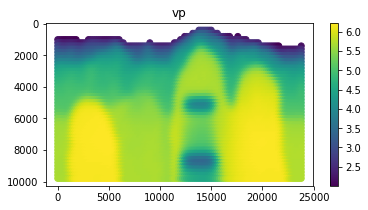

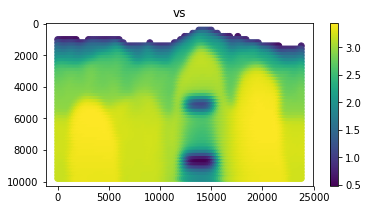

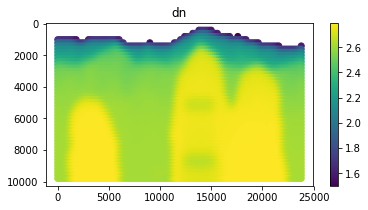

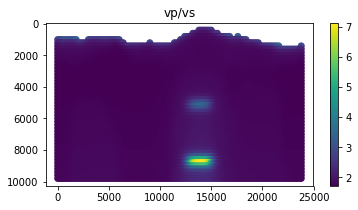

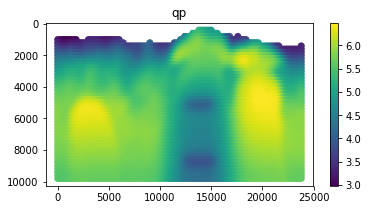

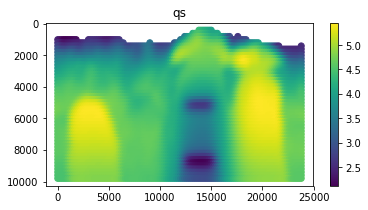

In [4]:
model = 'M5a'

pdir = '../data/' + model + '_xz_pos.npy'
xz_pos = np.load(pdir)
x = xz_pos[:, 0]
z = xz_pos[:, 1]

ldir = '../data/' + model + '_data_label.npy'
label = np.load(ldir)

cdir = '../data/' + model + '_clean_data.npy'
data = np.load(cdir)

ddir = '../data/' + model + '_init_data.npy'
idata = np.load(cdir)

means, stds = dp.compMeanStd(data)
norm_data = dp.normalize(data, means, stds)

col_n = ['vp', 'vs', 'dn', 'vp/vs', 'qp', 'qs', 'x', 'z']
mh.plot_fields(idata[:,:-2], x, z, titles=col_n[:-2])

In [5]:
means, stds = dp.compMeanStd(data)
norm_data = dp.normalize(data, means, stds)

In [23]:
#  Populate SOMs with whole dataset
# initialize hyperparameters
dim = 30
iter_cnt = 5000
lr = 0.5124390316684666
sigma = 2.189655172413793
seed = 10

som = sh.som_assemble(norm_data, seed, dim, lr, sigma)

start = timer()
som.train_random(norm_data, iter_cnt, verbose=False)
end = timer()
elapsed_time = end - start
logging.info("Time taken: %.6f", elapsed_time)

2019-08-27 20:10:29,178 | INFO : Time taken: 8.507190


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


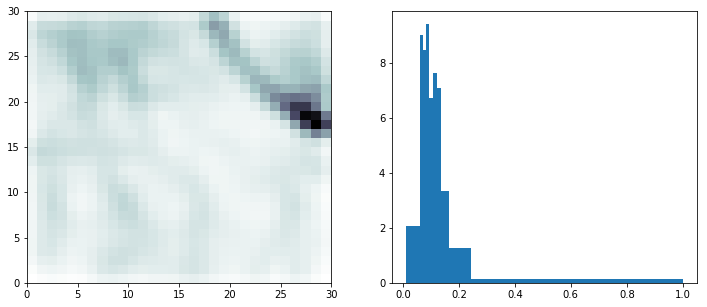

In [25]:
u_matrix = som.distance_map().T
watershed_bins = sh.plot_u_matrix(u_matrix)

2019-08-27 20:11:13,549 | INFO : Not enough labeled neighbor to perform KNN.
                      Will return the original inputted value.


/anaconda3/lib/python3.6/site-packages/skimage/segmentation/random_walker_segmentation.py:407: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  warn('Random walker only segments unlabeled areas, where '


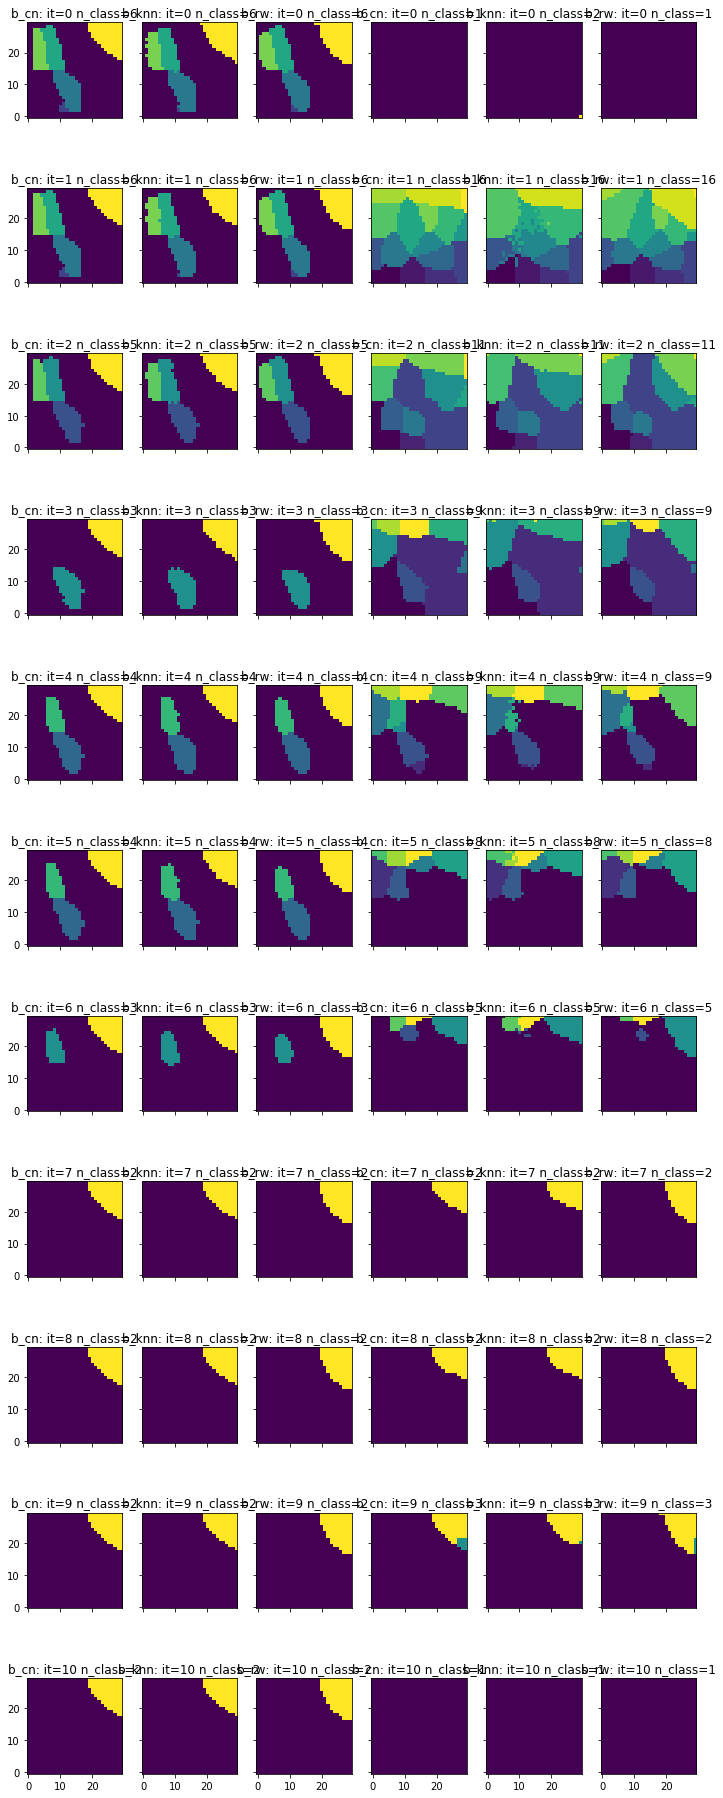

In [26]:
ws_labels = sh.watershed_level(u_matrix, watershed_bins, plot=True)

In [27]:
n_map = som.neuron_map(norm_data)

In [28]:
cluster_labels, sils, csc = sh.eval_ws(norm_data, ws_labels, n_map)

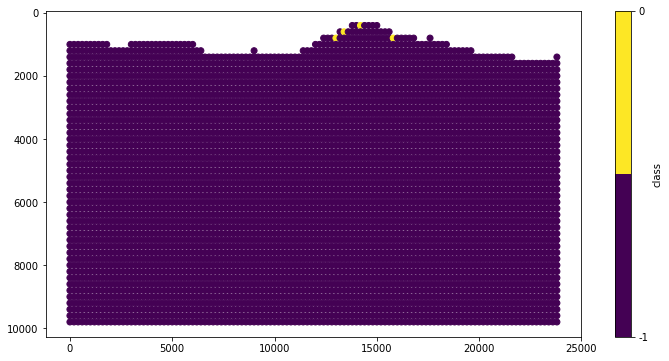

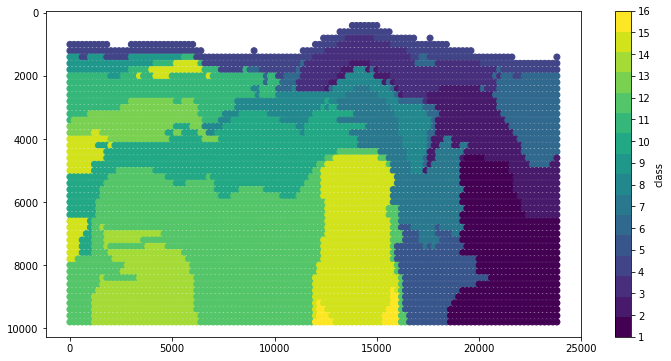

In [29]:
for c in cluster_labels:
    mh.plot_e_model(c, x, z, sep_label=True)

# SOMs with application of HDBScan
Since SOMs is a neural network that generates a u-matrix, this matrix could then be used as an input for other classification method.

## SOMs with HDBScan
The min_cluster_size of 41 and min_samples of 7 was found from HDBScan - Parameter Tuning

In [19]:
from acse_9_irp_wafflescore import HDBScanHelpers as hp

hdb, cluster_labels = hp.compute_hdb(n_map, 41, 7)

2019-08-27 20:09:06,617 | INFO : HDBScan elapsed time: 0.111033


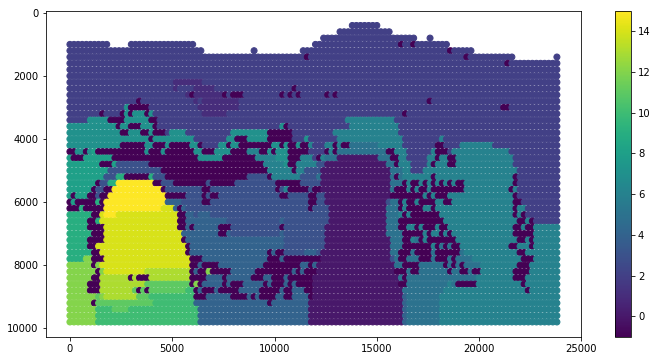

In [20]:
mh.plot_e_model(cluster_labels, x, z)

It can be seen that the same parameter from HDBScan cannot be used to optimize the SOMs-HDBScan.
Since this is the case, another parameter tuning must be done.

In [21]:
cluster_labels, avg_sils, avg_ch, min_size, min_sam = hp.random_search_hdb(n_map, (5,5), max_eval=20, label=label)

2019-08-27 20:09:17,643 | INFO : min_size=41, min_sam=7, sil=0.004936, ch=932.508989
2019-08-27 20:09:17,649 | INFO : ent=0.775425, pur=0.648902
2019-08-27 20:09:18,458 | INFO : min_size=32, min_sam=35, sil=-0.084708, ch=364.381964
2019-08-27 20:09:18,464 | INFO : ent=0.682649, pur=0.711015
2019-08-27 20:09:19,149 | INFO : min_size=41, min_sam=5, sil=0.115709, ch=880.147725
2019-08-27 20:09:19,155 | INFO : ent=0.763781, pur=0.660537
2019-08-27 20:09:19,210 | INFO : Random search using min_size = 18, min_sam = 34 result to very small / large number of clusters (n_clusters = 37)
2019-08-27 20:09:19,904 | INFO : min_size=36, min_sam=22, sil=-0.123880, ch=398.654060
2019-08-27 20:09:19,910 | INFO : ent=0.729315, pur=0.689998
2019-08-27 20:09:20,585 | INFO : min_size=46, min_sam=15, sil=0.014644, ch=1234.343674
2019-08-27 20:09:20,591 | INFO : ent=0.808595, pur=0.693188
2019-08-27 20:09:20,663 | INFO : Random search using min_size = 7, min_sam = 38 result to very small / large number of clu

-0.024344126364671703 563.9822251647512 24.0 43.0


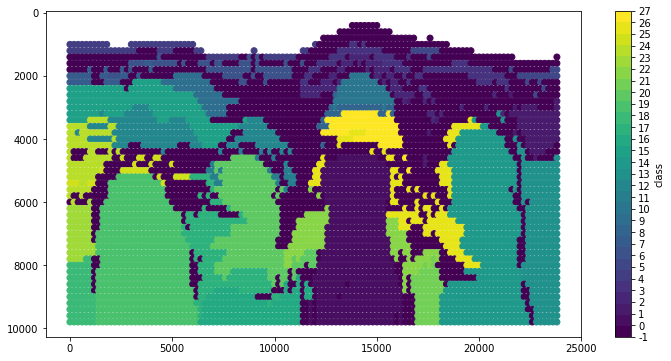

0.14436077474131906 1308.1722483479655 39.0 10.0


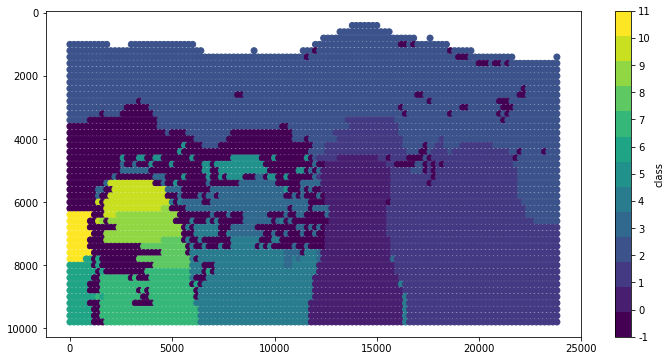

In [22]:
for i in range(cluster_labels.shape[0]):
    print(avg_sils[i], avg_ch[i], min_size[i], min_sam[i])
    mh.plot_e_model(cluster_labels[i], x, z, sep_label=True)

The result from using Model M5a on SOMs not good, and is not worth exploring.